This notebook recreates the following example using BET:  
http://madsjulia.github.io/Mads.jl/Examples/infogap/  
See the introduction of the documentation therein for more information about the problem setup. 

Author: Michael Pilosov  
Date: 06-09-2017

In [1]:
# Import modules
import numpy as np
import bet.calculateP.simpleFunP as simpleFunP
import bet.calculateP.calculateP as calculateP
import bet.postProcess.plotP as plotP
import bet.postProcess.plotDomains as plotD
import bet.sample as samp
import bet.sampling.basicSampling as bsam
from myModel import my_model

import time
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [6]:
num_input_samples = 2E5 # Note 20,000 samples is similar to what the regular grid would use
randomSampling = True # random or regular sampling?
grid_factor = 1 # for regular sampling only. how many per interval.

Define reference parameter. Recall that  
$$
y(t) = a t^n + bt + c
$$

The convention of ordering for our parameter $\lambda$ that we will use is  
$$
\lambda = [a, b, c, n]
$$

Since the data we are trying to match up for $t = [1,2,3,4]$ is $y(t) = [1,2,3,4]$, then we have two cases for $n$ that yield the following analytic solutions:  

$$ 
n = 0 \implies a+c=0, b=1 \\
n = 1 \implies a+b=1, c=0
$$

We then pick any viable reference parameter and map it to our 4-D output space.

In [24]:
a = 10*np.random.rand()-5 # choose any a between -5 and 5
# pick any one of the analytical solutions [a,b,c,n]
ref_param = np.array([[a, 1.0, -a, 0.0]])
# ref_param = np.array([[a, 1.0-a, 0.0, 1.0]])
Q_ref =  my_model(np.array(ref_param))
print ref_param[0], '=>', Q_ref[0]

[-1.46640719  1.          1.46640719  0.        ] => [ 1.  2.  3.  4.]


Next we define the sampler that will be used to create the discretization object, initialize 4-dimensional input parameter sample set object, and set up the parameter space domain (our prior/ansatz is uniform over this space) and generate the (random or regular) samples on which we will later form our probability measure. 

In [25]:
sampler = bsam.sampler(my_model)
input_samples = samp.sample_set(4)
input_samples.set_domain(np.array([ [-10.0, 10.0],
                                    [-10.0, 10.0], 
                                    [-5.0, 5.0], 
                                    [-3.0, 3.0] ]))

if randomSampling is True:
    input_samples = sampler.random_sample_set('random', input_samples, num_samples=num_input_samples)
else:
    # if regular sampling, use the integer grid in uncertainty box. 24,000 samples.
    input_samples = sampler.regular_sample_set(input_samples, num_samples_per_dim=grid_factor*np.array([20, 20, 10, 6])) 


A standard Monte Carlo (MC) assumption is that every Voronoi cell has the same volume. If a regular grid of samples was used, then the standard MC assumption is true. If the number of random samples is large enough for the dimension of the parameter space, the MC assumption is _practically_ true. To have accurate volumes of the randomly generated Voronoi cells, we can use emulation. 

In [26]:
MC_assumption = True
start_time = time.time()
# Estimate volumes of Voronoi cells associated with the parameter samples
if MC_assumption is False:
    input_samples.estimate_volume(n_mc_points=num_input_samples*50.0)
else:
    input_samples.estimate_volume_mc()

# Create the discretization object using the input samples
my_discretization = sampler.compute_QoI_and_create_discretization(input_samples,
                                               savefile = '4to4_discretization.txt.gz')
end_time = time.time()

So, using emulation on a lot of samples (particularly in a high-dimensional space) can lead to some cells getting _zero volume_, which is not good. It is also quite time-consuming. I suggest starting off with `MC_assumption = True`, and then running it without the MC assumption and figuring out a good multiplier above to avoid cells with zero volume. 

In [27]:
print 'time elapsed:', (end_time - start_time)/60
print 'number of unique volumes:', np.unique(my_discretization._input_sample_set._volumes).shape[0]

time elapsed: 0.0115591327349
number of unique volumes: 1


Next, we define a distribution on our output space, which is $\pm 1$ in each dimension. The argument `rect_size` refers to the length of the interval, which will thus be 2. The number of cells per dimension raised to the fourth power will determine the number of unique probabilities over the support of the inverse image. 

In [28]:
randomDataDiscretization = False
if randomDataDiscretization is False:
    simpleFunP.regular_partition_uniform_distribution_rectangle_size(
            data_set=my_discretization, Q_ref=Q_ref[0], rect_size=2.0,
            cells_per_dimension = 4)
else:
    simpleFunP.uniform_partition_uniform_distribution_rectangle_size(
        data_set=my_discretization, Q_ref=Q_ref[0], rect_size=2.0,
        M=50, num_d_emulate=1E5)

Finally, we calculate the probability measure over the parameter space $\Lambda$.

In [29]:
calculateP.prob(my_discretization)

In [30]:
plot_disc = 10 # plotting discretization

# calculate 2d marginal probs
(bins2D, marginals2D) = plotP.calculate_2D_marginal_probs(input_samples,
                                                        nbins = plot_disc*np.ones(4))

# smooth 2d marginals probs (optional)
# marginals2D = plotP.smooth_marginals_2D(marginals2D, bins, sigma=0.2)

# plot 2d marginals probs
plotP.plot_2D_marginal_probs(marginals2D, bins2D, input_samples, filename = "linearMap",
                             lam_ref=ref_param[0], file_extension = ".eps", plot_surface=False)

# calculate 1d marginal probs
(bins1D, marginals1D) = plotP.calculate_1D_marginal_probs(input_samples,
                                                        nbins = plot_disc*np.ones(4))
#                                                         nbins = plot_disc*np.array([20, 20, 10, 6]))
# smooth 1d marginal probs (optional)
# marginals1D = plotP.smooth_marginals_1D(marginals1D, bins1D, sigma=0.1)


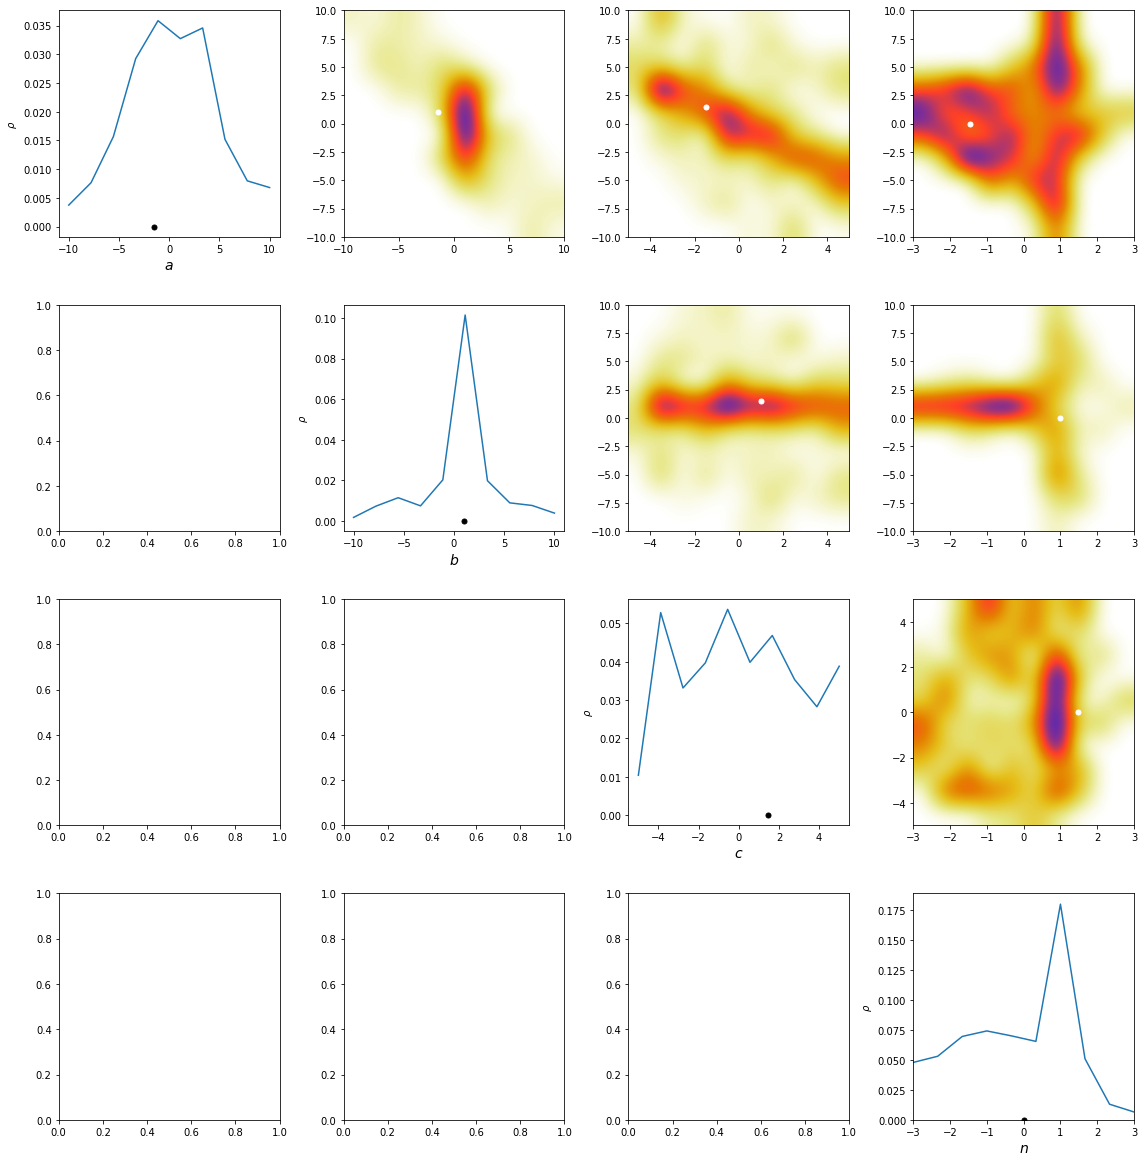

In [31]:
plt.rcParams['figure.figsize'] = (16, 16)
lambda_label = ['a','b','c','n']
f, ax = plt.subplots(4,4)
for i in xrange(4):
    for j in xrange(4):
        lam_domain = input_samples.get_domain()
        if i==j:
            x_range = np.linspace(lam_domain[i, 0], lam_domain[i, 1],
                    len(bins1D[i])-1)
            ax[i,j].plot(x_range, marginals1D[i]/(bins1D[i][1]-bins1D[i][0]))
#             ax[i,j].set_ylim([0, 1.05*np.max(marginals1D[i]/(bins1D[i][1]-bins1D[i][0]))])
            plt.axis([lam_domain[i][0], lam_domain[i][1], 
                      0, 1.05*np.max(marginals1D[i]/(bins1D[i][1]-bins1D[i][0]))])
            ax[i,j].plot(ref_param[0,i], 0.0, 'ko', markersize=5)
            ax[i,j].set_ylabel(r'$\rho$')
            ax[i,j].set_xlabel(r'$%s$'%lambda_label[i],fontsize=14)
            
        elif i<j:
#             ax[i,j].scatter(marginals1D[i], marginals1D[j])
            boxSize = (bins2D[i][1]-bins2D[i][0])*(bins2D[j][1]-bins2D[j][0])
            ax[i,j].imshow(marginals2D[(i,j)]/boxSize, 
                          interpolation='bicubic', cmap=cm.CMRmap_r, 
                          extent=[lam_domain[j][0], lam_domain[j][1],
                          lam_domain[i][0], lam_domain[i][1]], origin='lower',
                          vmax=marginals2D[(i, j)].max()/boxSize, vmin=0, aspect='auto')
            ax[i,j].plot(ref_param[0,i], ref_param[0,j], 'wo', markersize=5)
            plt.axis([lam_domain[i][0], lam_domain[i][1], lam_domain[j][0],
                lam_domain[j][1]])
            plt.tight_layout()
#             ax[i,j].set_ylabel(r'$%s$'%lambda_label[j])
        
f.subplots_adjust(hspace=0.3)
plt.show()

In [ ]:
# plt.scatter(marginals1D[0],marginals1D[3])
# plt.show()
np.unique(input_samples._probabilities)